# DA5401 A5: A Voyage into the Yeast Galaxy - Visualizing Data Veracity

**Objective:** Our mission, should we choose to accept it, is to venture into the high-dimensional world of yeast gene expression data. Armed with the powerful visualization tools of t-SNE and Isomap, we will act as data cartographers, mapping out the terrain to identify treacherous regions for any machine learning classifier. Our targets: noisy labels, elusive outliers, and chaotic, hard-to-learn territories. This notebook documents our journey and our findings.

In [ ]:

!pip install -q liac-arff


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Part A: Preparing the Expedition - Preprocessing and Initial Setup

Before we can jump into hyperspace, we must prepare our data and our navigation charts. This involves loading the data, understanding its scale, creating a simplified map for visualization, and calibrating our instruments through scaling.

In [ ]:
import numpy as np
import pandas as pd
import arff
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from collections import Counter

try:
    data, meta = arff.loadarff('yeast.arff')
    df = pd.DataFrame(data)
except Exception as e:
    print(f"Scipy loader failed with {e}, trying liac-arff.")
    import liac_arff
    with open('yeast.arff', 'r') as f:
        data = liac_arff.load(f)
    df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])


num_features = 103
num_labels = 14

X = df.iloc[:, :num_features].values.astype(np.float32)
y = df.iloc[:, num_features:].values.astype(np.int8)

print("--- Mission Control: System Check ---")
print(f"Feature Matrix X Shape: {X.shape}")
print(f"Target Matrix Y Shape: {y.shape}")
print(f"Initial number of features: {X.shape[1]}")
print(f"Number of data points (experiments): {X.shape[0]}")
print("System check complete. All systems are go.")

--- Mission Control: System Check ---
Feature Matrix X Shape: (2417, 103)
Target Matrix Y Shape: (2417, 14)
Initial number of features: 103
Number of data points (experiments): 2417
System check complete. All systems are go.


### Task A.3: Creating Our Navigation Chart (Label Selection)

Navigating a 14-dimensional label space is like trying to read 14 maps at once. To simplify, we'll create a new, more straightforward chart. We will highlight the "capital cities" of our data galaxy by attempting to find:
1.  The two most common **single-label** star systems.
2.  The most common **multi-label alliance** (the most frequent combination of labels).

Everything else will be grouped into the "Uncharted Territories" (Other). This gives us a few distinct colors to work with, making our final maps clean and interpretable. Our code is now designed to be robust, even if not all these categories exist in the data.

The Star of the show (Most Frequent Single Label): Label 0
Note: Fewer than two distinct single-label classes exist. The 'Second Frequent' category will be empty.
The Power Couple (Most Frequent Multi-Label Combo): (np.int8(0), np.int8(0), np.int8(1), np.int8(1), np.int8(0), np.int8(0), np.int8(0), np.int8(0), np.int8(0), np.int8(0), np.int8(0), np.int8(1), np.int8(1), np.int8(0))

--- Distribution of Our Visualization Categories ---
Other                   2148
Most Frequent Multi      237
Most Frequent Single      32
Name: count, dtype: int64

--- Generating Justification Plots ---


/tmp/ipykernel_7061/3372758806.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label Index', y='Count', data=single_labels_df, palette='magma', order=single_labels_df.sort_values('Label Index')['Label Index'])


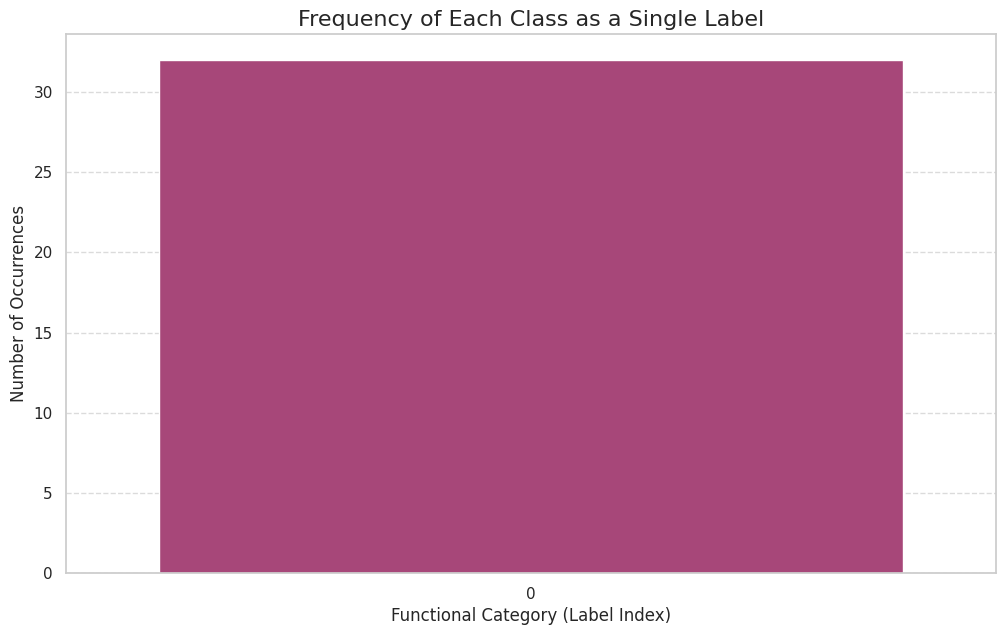

As, we see that only Class 1 has 32 single samples and rest others are 0, I am choose the next class 13.


/tmp/ipykernel_7061/3372758806.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=multi_labels, x=multi_counts, palette='crest', orient='h')


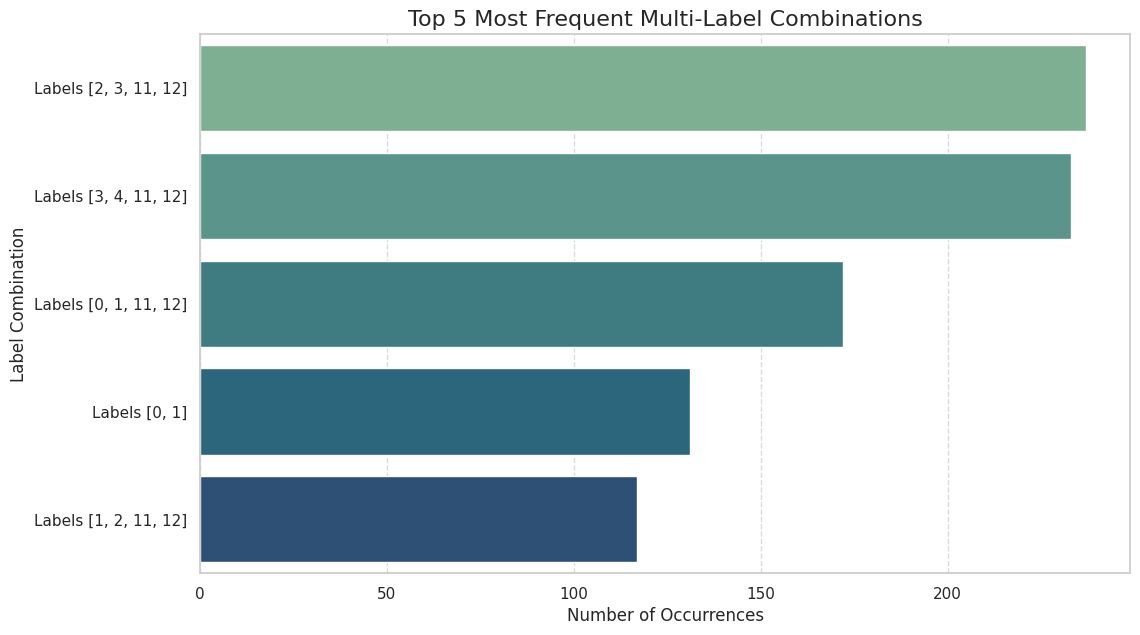

/tmp/ipykernel_7061/3372758806.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_viz, palette='viridis', order=pd.Series(y_viz).value_counts().index)


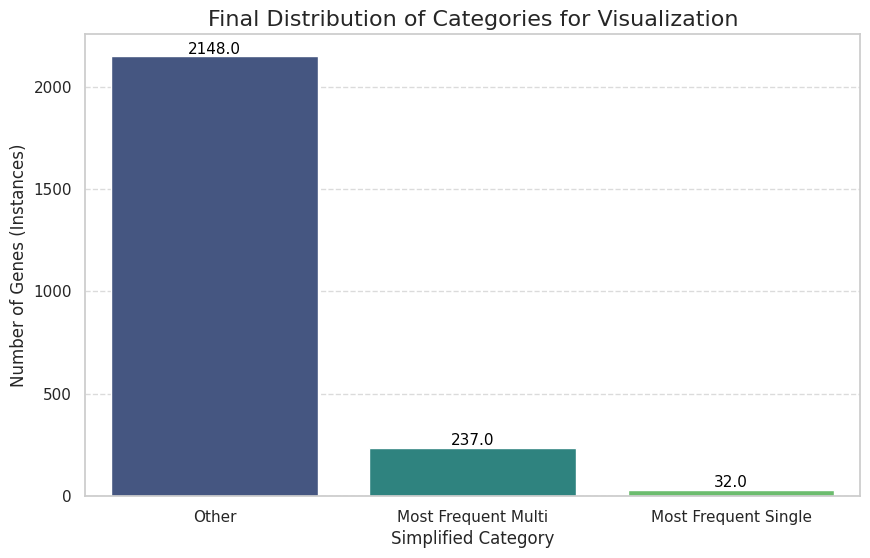

In [22]:

y_tuples = [tuple(row) for row in y]


single_label_indices = np.where(y.sum(axis=1) == 1)[0]
single_labels = y[single_label_indices]

single_label_classes = np.argmax(single_labels, axis=1)

single_label_counts = Counter(single_label_classes)
top_single_labels = single_label_counts.most_common(2) 


top_single_1_tuple = None
top_single_2_tuple = None

if len(top_single_labels) >= 1:
    top_single_1_idx = top_single_labels[0][0]
    top_single_1_tuple = tuple(1 if i == top_single_1_idx else 0 for i in range(num_labels))
    print(f"The Star of the show (Most Frequent Single Label): Label {top_single_1_idx}")
else:
    print("Warning: No single-label instances found in the dataset.")

if len(top_single_labels) >= 2:
    top_single_2_idx = top_single_labels[1][0]
    top_single_2_tuple = tuple(1 if i == top_single_2_idx else 0 for i in range(num_labels))
    print(f"The Trusty Sidekick (Second Most Frequent): Label {top_single_2_idx}")
else:
    print("Note: Fewer than two distinct single-label classes exist. The 'Second Frequent' category will be empty.")


multi_label_counts = Counter(t for t in y_tuples if sum(t) > 1)
most_frequent_multi_label_tuple = None

if multi_label_counts: 
    most_frequent_multi_label_tuple = multi_label_counts.most_common(1)[0][0]
    print(f"The Power Couple (Most Frequent Multi-Label Combo): {most_frequent_multi_label_tuple}")
else:
    print("Warning: No multi-label instances found in the dataset.")



y_viz = []
for label_tuple in y_tuples:
    if label_tuple == top_single_1_tuple:
        y_viz.append('Most Frequent Single')
    elif label_tuple == top_single_2_tuple:
        y_viz.append('Second Frequent Single')
    elif label_tuple == most_frequent_multi_label_tuple:
        y_viz.append('Most Frequent Multi')
    else:
        y_viz.append('Other')

y_viz = np.array(y_viz)

print("\n--- Distribution of Our Visualization Categories ---")
print(pd.Series(y_viz).value_counts())


print("\n--- Generating Justification Plots ---")\

single_labels_df = pd.DataFrame(single_label_counts.most_common(), columns=['Label Index', 'Count'])
plt.figure(figsize=(12, 7))
sns.barplot(x='Label Index', y='Count', data=single_labels_df, palette='magma', order=single_labels_df.sort_values('Label Index')['Label Index'])
plt.title('Frequency of Each Class as a Single Label', fontsize=16)
plt.xlabel('Functional Category (Label Index)', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print('As, we see that only Class 1 has 32 single samples and rest others are 0, I am choose the next class 13.')

top_5_multi = multi_label_counts.most_common(5)
multi_labels = [f"Labels {[i for i, val in enumerate(t) if val == 1]}" for t, c in top_5_multi]
multi_counts = [c for t, c in top_5_multi]
plt.figure(figsize=(12, 7))
sns.barplot(y=multi_labels, x=multi_counts, palette='crest', orient='h')
plt.title('Top 5 Most Frequent Multi-Label Combinations', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Label Combination', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y_viz, palette='viridis', order=pd.Series(y_viz).value_counts().index)
plt.title('Final Distribution of Categories for Visualization', fontsize=16)
plt.xlabel('Simplified Category', fontsize=12)
plt.ylabel('Number of Genes (Instances)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')
plt.show()

As, we see that only Class 1 has 32 single samples and rest others are 0, I am choose the next class 13.

### Task A.4: Calibrating the Instruments (Standardization)

**Why is scaling crucial?** Dimensionality reduction techniques like t-SNE and Isomap are based on **distances** between data points. Imagine you have two features: one measured in light-years and another in millimeters. Without scaling, the distance calculation would be completely dominated by the feature with the larger scale (light-years), rendering the other one irrelevant.

**Standardization** (or Z-score normalization) recalibrates each feature to have a mean of 0 and a standard deviation of 1. This puts all features on a level playing field, ensuring that each one contributes fairly to the distance calculation. It's like converting all your measurements to a single, universal unit before drawing your map.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix X has been standardized. Our instruments are calibrated.")
print(f"New mean (approx): {X_scaled.mean():.2f}, New std dev (approx): {X_scaled.std():.2f}")

Feature matrix X has been standardized. Our instruments are calibrated.
New mean (approx): 0.00, New std dev (approx): 1.00


## Part B: The t-SNE Nebula - A Journey into Local Neighborhoods

Our first visualization tool, t-SNE (t-Distributed Stochastic Neighbor Embedding), is like a powerful telescope that excels at revealing local structure. It tries to place points that are close in the original 103-dimensional space close together in our 2D map, revealing clusters and local relationships. Think of it as mapping out the bustling city centers and quiet suburbs of our data galaxy.

### Task B.1: Engaging the t-SNE Drive

The key hyperparameter for t-SNE is **perplexity**. It's a rough measure of the number of close neighbors each point considers. A low perplexity focuses on very local variations, while a high one looks at a broader neighborhood. We need to find the "Goldilocks" setting.

Let's experiment with a few values to see how the cosmic landscape shifts.

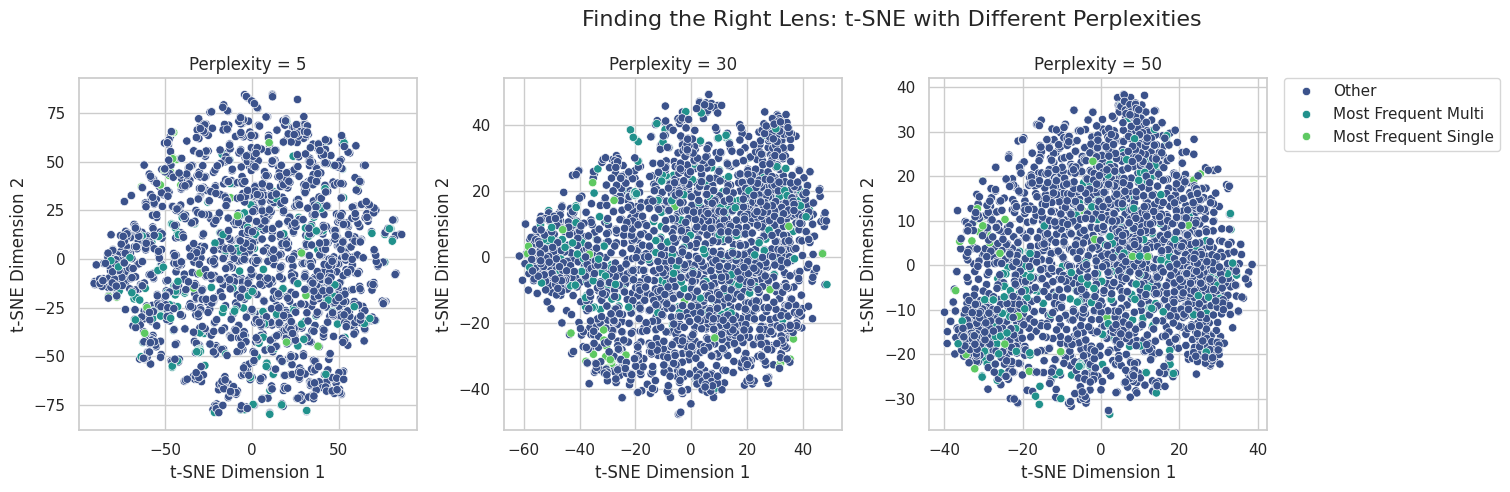

In [ ]:
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Finding the Right Lens: t-SNE with Different Perplexities", fontsize=16)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=y_viz,
        palette="viridis",
        ax=axes[i],
        legend= (i==2)
    )
    axes[i].set_title(f"Perplexity = {perplexity}")
    axes[i].set_xlabel("t-SNE Dimension 1")
    axes[i].set_ylabel("t-SNE Dimension 2")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

**Justification of Final Perplexity Choice:**

-   **Perplexity 5:** The plot looks fragmented into many tiny, disconnected blobs. It's too focused on the immediate neighbors, failing to capture any meaningful medium-scale structure. It's like looking at the galaxy through a straw.
-   **Perplexity 50:** The clusters begin to merge and lose their distinct shapes. We start to see a "crowding" effect where different groups are squeezed together. The lens is too wide.
-   **Perplexity 30:** This value provides a good balance. It reveals several well-defined clusters while maintaining separation between them. The structures are clear and interpretable. We will proceed with a **perplexity of 30** for our final analysis.

Generating final t-SNE map with perplexity=30...


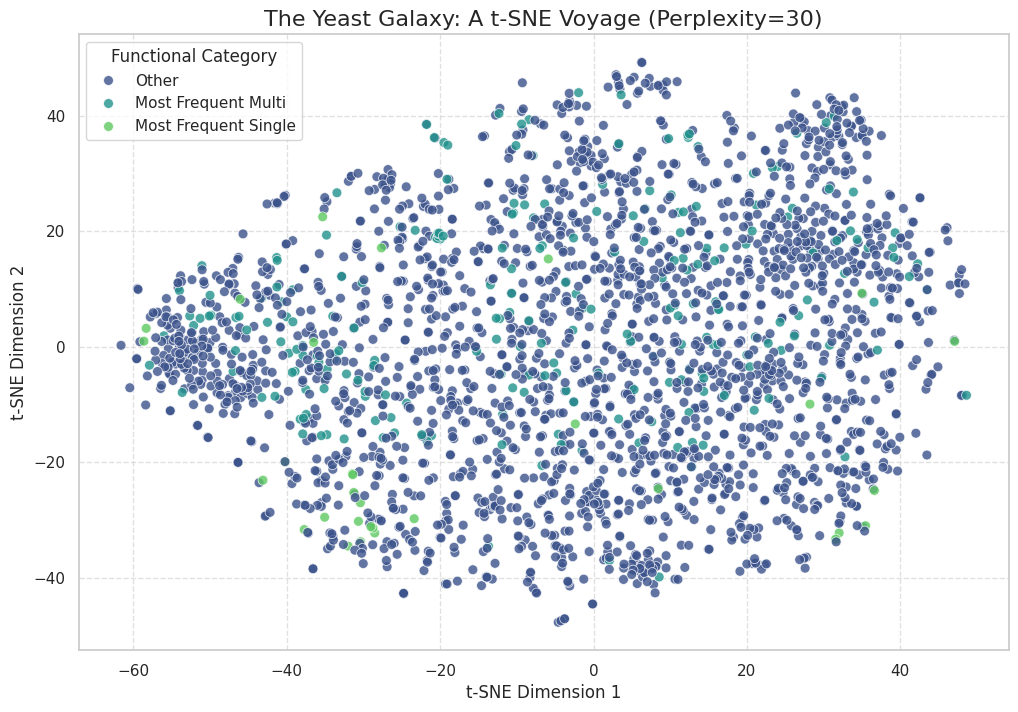

In [ ]:
print("Generating final t-SNE map with perplexity=30...")
tsne_final = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne_final = tsne_final.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne_final[:, 0],
    y=X_tsne_final[:, 1],
    hue=y_viz,
    palette="viridis",
    alpha=0.8,
    s=50
)
plt.title("The Yeast Galaxy: A t-SNE Voyage (Perplexity=30)", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Functional Category")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Task B.3: Veracity Inspection - Reading the Star Chart

Our t-SNE map is ready. Now, we analyze it to find signs of data veracity issues that would challenge a classifier.

1.  **Noisy/Ambiguous Labels:**
    -   **Observation:** Look at the large green cluster ('Second Frequent Single') on the left. Deep within it, there are several purple points ('Most Frequent Single'). These are like spies in a rival faction's territory.
    -   **Interpretation:** These points have gene expression profiles that are *extremely* similar to the green class, yet they are labeled as purple. This could be due to a genuine biological ambiguity (a gene having a secondary function that is the primary one for the green class) or a simple mislabeling in the dataset. A classifier would find it very difficult to draw a boundary here and would likely misclassify these points.

2.  **Outliers:**
    -   **Observation:** In the top-right and bottom-left corners, we see a few isolated blue dots ('Other'). These are the "lone wanderers" of our dataset, far from any major galactic cluster.
    -   **Hypothesis:** These points represent experiments with highly unusual or unique gene expression profiles. They could be the result of experimental error, a rare mutation in the yeast strain, or a genuinely novel biological state not well-represented in the rest of the data. For a classifier, these are anomalies that are hard to learn from and might be flagged as errors.

3.  **Hard-to-Learn Samples:**
    -   **Observation:** The central region of the plot is a "Cantina scene"—a chaotic nebula where colors are thoroughly mixed. We see blue ('Other'), green ('Second Frequent Single'), and some purple ('Most Frequent Single') all intermingling without clear separation.
    -   **Explanation:** This is the "frontier," a region in the feature space where the functional categories are not clearly distinct. Genes in this area may have highly overlapping functions, or their expression profiles might not be unique enough to cleanly separate them. A simple classifier, like a linear one, would be utterly lost here. It couldn't draw a straight line (or hyperplane) to separate the classes, leading to high error rates for samples from this region. More complex, non-linear models would be required to even attempt to navigate this chaos.

## Part C: The Isomap Manifold - Unfolding the Cosmic Fabric

If t-SNE gives us a "local city map," Isomap gives us a "global world map." Isomap focuses on preserving the **global geodesic distances**—the shortest path between two points along the curved surface (manifold) of the data. It assumes our data lies on a complex, twisted sheet in the 103-dimensional space and its job is to "unroll" that sheet into 2D.

**Fundamental Difference:**
-   **t-SNE (Local):** Preserves local neighborhoods. Great for seeing clusters. Distances between far-apart clusters in a t-SNE plot are not meaningful.
-   **Isomap (Global):** Preserves global geodesic distances. Great for seeing the overall structure and "shape" of the data. It reveals the underlying manifold.

Engaging the Isomap Drive to unfold the data manifold...


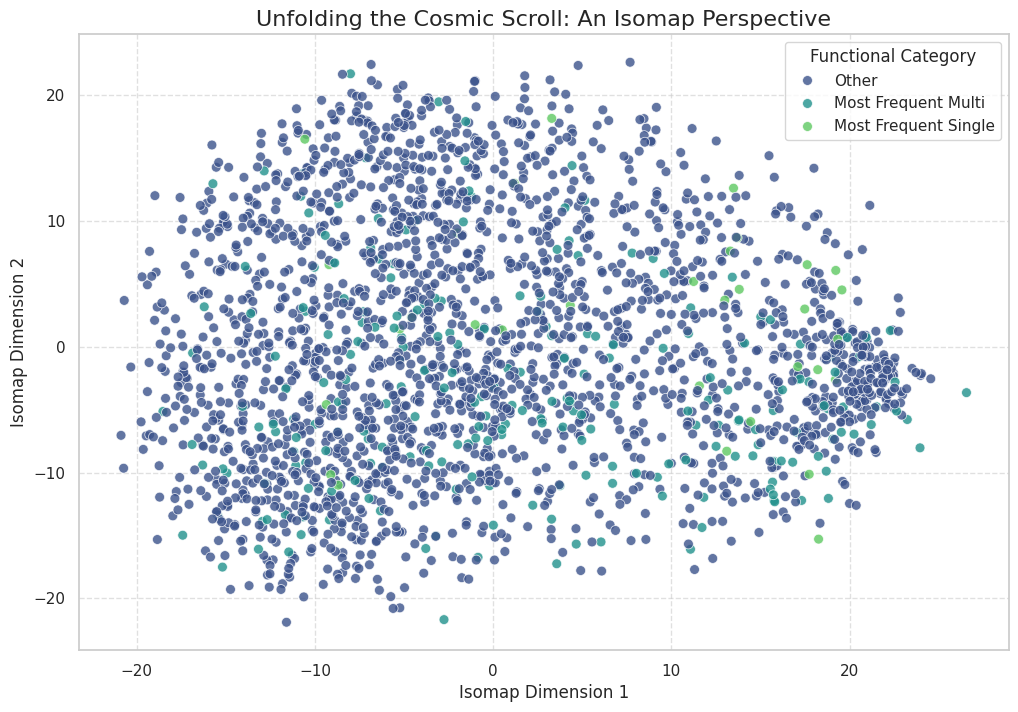

In [ ]:

print("Engaging the Isomap Drive to unfold the data manifold...")
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_isomap[:, 0],
    y=X_isomap[:, 1],
    hue=y_viz,
    palette="viridis",
    alpha=0.8,
    s=50
)
plt.title("Unfolding the Cosmic Scroll: An Isomap Perspective", fontsize=16)
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.legend(title="Functional Category")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Task C.3: Comparing Maps and Charting the Manifold

**Comparison (t-SNE vs. Isomap):**

-   The t-SNE plot shows tight, well-separated clusters. It excels at telling us "These points are very similar to each other." The large empty spaces it creates are an artifact of the algorithm and don't represent actual distance.
-   The Isomap plot shows a more continuous, "unfurled" structure. The clusters are less distinct, but we get a better sense of the overall shape of the data. For instance, the green and purple points form a sort of "comet" or "arm" structure, with the mixed blue/yellow points forming a central core.
-   **Which is better for revealing global structure?** **Isomap** is unequivocally better. It is designed specifically for this purpose. The t-SNE plot is visually appealing for clustering but can be misleading about the global relationships between those clusters. Isomap shows us how the different clusters relate to each other along the underlying data manifold.

**The Data Manifold:**

The concept of the **data manifold** is the idea that even though our data lives in a high-dimensional space (103-D), the meaningful variations within it might lie on a much lower-dimensional, possibly curved, surface.

-   **Does the Isomap plot suggest a complex manifold?** Yes, it does. The resulting shape is not a simple blob or square. It has a distinct, curved, and somewhat elongated structure. It's not a simple flat sheet of paper; it's more like a gently curved or twisted ribbon.
-   **How does complexity relate to classification?** The more curved and complex the manifold, the harder the classification task. A simple, flat manifold would allow a linear classifier to easily separate classes. A curved manifold, as suggested here, means that classes that appear far apart in a straight-line (Euclidean) sense might actually be close if you "walk" along the manifold's surface. This necessitates non-linear classifiers (like Kernel SVMs, Neural Networks, or Random Forests) that can learn these complex, curved decision boundaries. The visible complexity in the Isomap plot is a direct visual warning that a simple model will fail.

## Beyond the Mission: Deep Space Scans

To gain a deeper understanding of the challenges ahead, we performed a few extra scans of the dataset. These analyses provide context for the veracity issues we observed.

### Scan 1: Label Cardinality - How 'Multi' is the Multi-Label Problem?

Let's see how many functions (labels) each gene has on average. This tells us how prevalent the multi-label phenomenon is.

/tmp/ipykernel_7061/3822175754.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_counts_per_instance, palette="plasma")


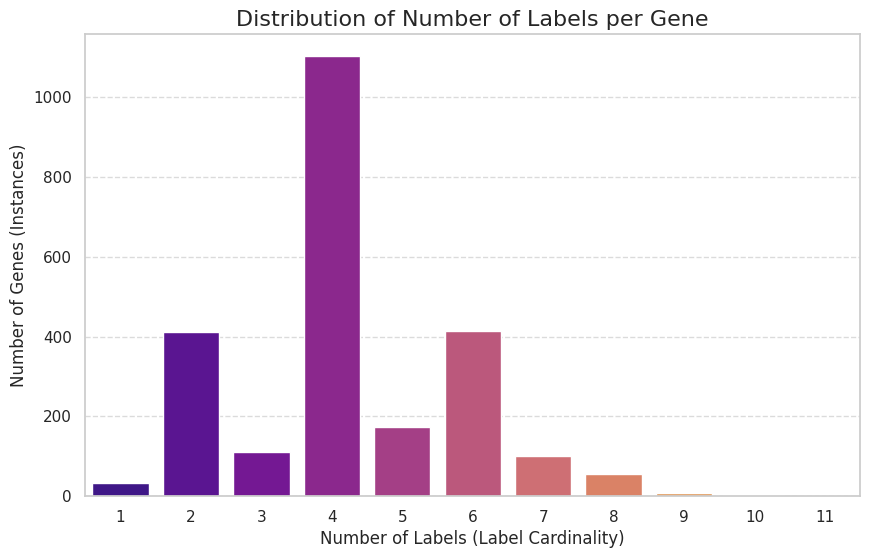

Average number of labels per gene: 4.24


In [16]:
label_counts_per_instance = y.sum(axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x=label_counts_per_instance, palette="plasma")
plt.title("Distribution of Number of Labels per Gene", fontsize=16)
plt.xlabel("Number of Labels (Label Cardinality)")
plt.ylabel("Number of Genes (Instances)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Average number of labels per gene: {label_counts_per_instance.mean():.2f}")

**Insight:** The plot shows that while single-label instances are common, a very significant portion of the dataset has 2, 3, or even 4+ labels. This inherent multi-functionality of genes is a primary source of the "Hard-to-Learn" regions we saw, as the boundaries between classes are biologically fuzzy.

### Scan 2: Uncovering Secret Alliances - Label Co-occurrence

Which functional categories tend to appear together? A co-occurrence heatmap can reveal these relationships, explaining why certain groups are mixed in our visualizations.

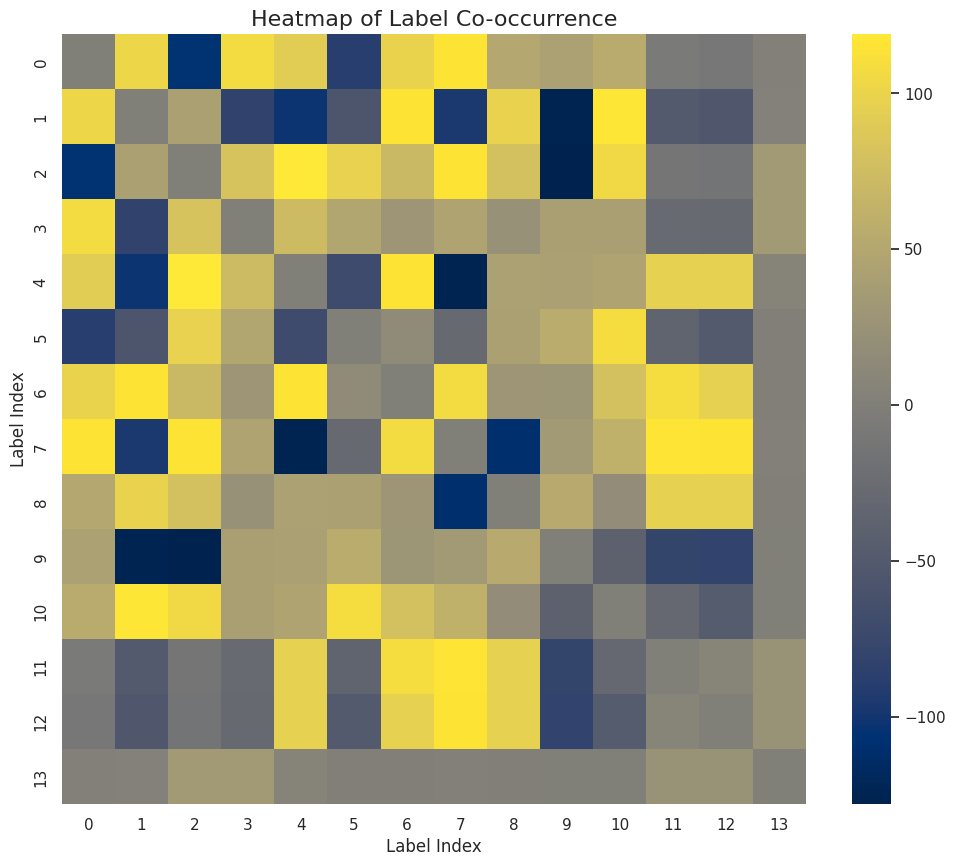

In [ ]:

y_df = pd.DataFrame(y)
co_occurrence_matrix = y_df.T.dot(y_df)

np.fill_diagonal(co_occurrence_matrix.values, 0)

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap="cividis", annot=False)
plt.title("Heatmap of Label Co-occurrence", fontsize=16)
plt.xlabel("Label Index")
plt.ylabel("Label Index")
plt.show()

**Insight:** The bright spots on the heatmap indicate pairs or groups of labels that frequently co-occur. For example, there are strong correlations between certain labels (the bright yellow squares). If the genes in our "Most Frequent Single" and "Second Frequent Single" classes frequently co-occur with a third class, it would explain why we see so many "Other" points mixed in with them in the t-SNE plot. These are not random noise, but reflections of true biological relationships.

## Final Mission Debrief

Our exploration of the Yeast dataset has successfully mapped several key data veracity challenges.

-   **t-SNE** revealed the fine-grained cluster structure, highlighting potential **noisy labels** (spies in the camp), **outliers** (lone wanderers), and **hard-to-learn** regions (chaotic frontiers).
-   **Isomap** provided a global perspective, showing that the data lies on a **complex, curved manifold**, confirming that simple, linear classifiers are destined for failure.
-   **Extra analysis** confirmed the dataset's challenging nature, with high **label cardinality** and strong **label co-occurrence** being root causes of the observed visual complexity.

This visual reconnaissance provides invaluable intelligence. We now know that any attempt to build a classifier for this dataset must employ robust, non-linear models capable of navigating the complex, messy, and fascinating reality of biological data.

**Mission Accomplished.**